In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.5.1-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]='/content/spark-3.5.1-bin-hadoop3'

In [ ]:
!pip install -q findspark
import findspark

In [ ]:
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.5.1-bin-hadoop3'

In [ ]:
from pyspark.sql.functions import col

In [ ]:
import pyspark
sc = pyspark.SparkContext(appName="learningpyspark_33")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Analysis of Theft').getOrCreate()

df = spark.read.csv('/content/drive/MyDrive/hiscrimdata.csv', header=True, inferSchema=True)

In [ ]:
df = df.filter(
    (col("Type") == "Theft from Vehicle") |
    (col("Type") == 'Theft of Vehcile') |
    (col("Type") == 'Theft of Bicycle') |
    (col("Type") == 'Other Theft')
)

df.show()

+------------------+----+-----+---+----+------+------------------+--------------------+-----------+------------+
|              TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|     HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+------------------+----+-----+---+----+------+------------------+--------------------+-----------+------------+
|Theft from Vehicle|2006|    3|  4|  20|    30|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    3|  5|  11|    30|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    4| 16|   0|     1|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    6| 11|  17|    45|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    8|  5|  20|     0|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    8|  7|   0|     0|DAVIE ST / HOWE ST|Central Business ...|490748.59

In [ ]:
from pyspark.sql.functions import col, sum

#Find Missing values
missing_data_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data_counts.show()

+----+----+-----+---+----+------+-------------+-------------+---+---+
|TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|HUNDRED_BLOCK|NEIGHBOURHOOD|  X|  Y|
+----+----+-----+---+----+------+-------------+-------------+---+---+
|   0|   0|    0|  0|   0|     0|            6|            0|  0|  1|
+----+----+-----+---+----+------+-------------+-------------+---+---+



In [ ]:
#Process data
df = df.dropDuplicates() # Remove duplicate rows
df.show()

+------------------+----+-----+---+----+------+--------------------+--------------------+-----------+------------+
|              TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|       HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+------------------+----+-----+---+----+------+--------------------+--------------------+-----------+------------+
|Theft from Vehicle|2003|    9| 13|  16|     0|DAVIE ST / PACIFI...|Central Business ...|491162.9519| 5457932.715|
|Theft from Vehicle|2012|    2|  1|  23|    30|DAVIE ST / PACIFI...|Central Business ...|491162.9519| 5457932.715|
|Theft from Vehicle|2007|   10|  6|  17|     0|DAVIE ST / RICHAR...|Central Business ...|490961.8124| 5458133.405|
|Theft from Vehicle|2009|    9| 19|  22|     0|DAVIE ST / SEYMOU...|Central Business ...|490894.1116|5458201.4644|
|Theft from Vehicle|2011|    1| 17|  16|    15|DENMAN ST / W GEO...|            West End|490276.8955|5459994.7654|
|Theft from Vehicle|2003|    7| 27|   1|     0|DISCOVERY ST / W ...|   Dunbar-So

In [ ]:
df_summary = df.describe()
df_summary.show()

+-------+----------------+------------------+------------------+------------------+------------------+-----------------+--------------------+---------------+-----------------+------------------+
|summary|            TYPE|              YEAR|             MONTH|               DAY|              HOUR|           MINUTE|       HUNDRED_BLOCK|  NEIGHBOURHOOD|                X|                 Y|
+-------+----------------+------------------+------------------+------------------+------------------+-----------------+--------------------+---------------+-----------------+------------------+
|  count|          231057|            231057|            231057|            231057|            231057|           231057|              231051|         231057|           231057|            231056|
|   mean|            NULL|2011.9456930540948| 6.506693153637414|15.311156987236915|13.797686285202353|19.63317276689302|                NULL|           NULL|492061.8438430389|5457330.1485336535|
| stddev|            NULL

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws, col, to_date, date_format, sum, avg
from pyspark.sql.functions import dayofmonth, ceil


df = df.withColumn("Date", concat_ws("-", col("YEAR"), col("MONTH"), col("DAY")))
df = df.withColumn("Date", col("Date").cast("date"))

df = df.withColumn("day", dayofmonth("Date"))
df = df.withColumn("week_of_month", ceil(df.day / 7))

df.createOrReplaceTempView("CrimeData")

What are the most common types of theft offenses (e.g., theft from vehicle, theft of bicycle, other theft)?

In [ ]:
query1 = """
SELECT Type, COUNT(*) AS Count
FROM CrimeData
GROUP BY Type
ORDER BY Count DESC
"""

result1 = spark.sql(query1)
result1.show()

result1_df = result1.toPandas()


+------------------+------+
|              Type| Count|
+------------------+------+
|       Other Theft|175559|
|  Theft of Bicycle| 33763|
|Theft from Vehicle| 21735|
+------------------+------+



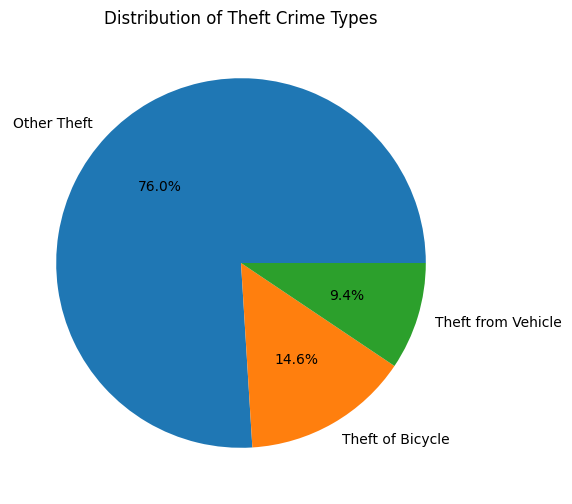

In [ ]:
total_crimes = result1_df['Count'].sum()
result1_df['Percentage'] = (result1_df['Count'] / total_crimes) * 100

# Visualize overall frequency with a pie chart
plt.figure(figsize=(6, 6))
plt.pie(result1_df['Percentage'], labels=result1_df['Type'], autopct='%1.1f%%')
plt.title('Distribution of Theft Crime Types')
plt.show()

How do theft crime rates fluctuate throughout the week?

In [ ]:
q2 = spark.sql("""
SELECT TYPE, week_of_month AS Week, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, week_of_month
ORDER BY Count DESC
""")

q2_df = q2.toPandas()

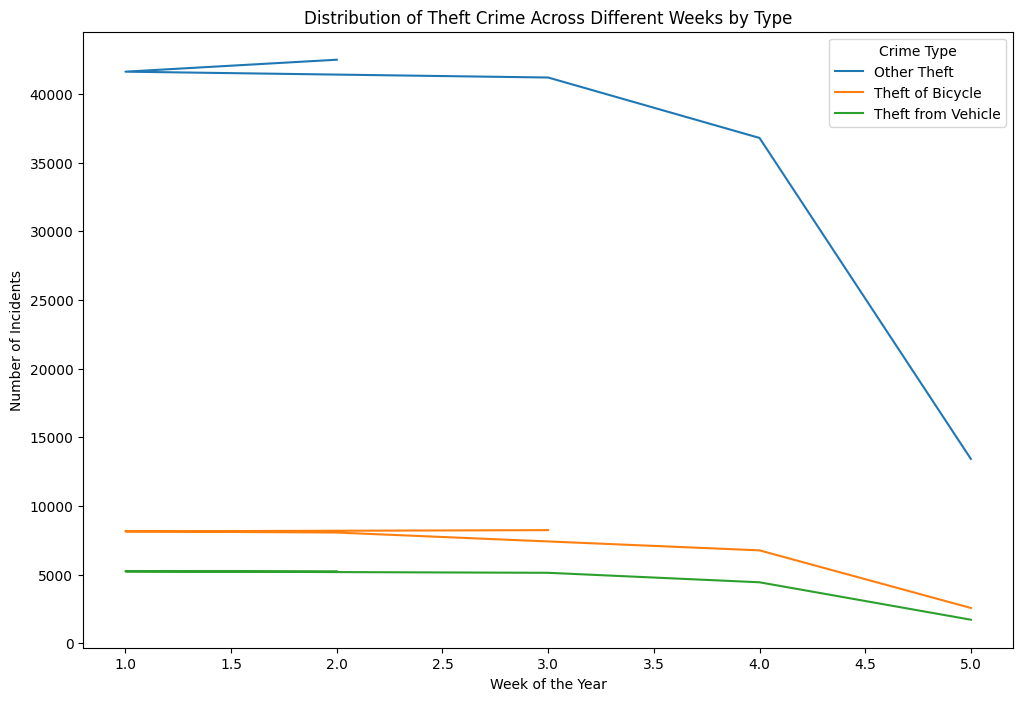

In [ ]:
# Create a line plot
plt.figure(figsize=(12, 8))
for crime_type in q2_df['TYPE'].unique():
    subset = q2_df[q2_df['TYPE'] == crime_type]
    plt.plot(subset['Week'], subset['Count'], label=crime_type)

plt.xlabel('Week of the Year')
plt.ylabel('Number of Incidents')
plt.title('Distribution of Theft Crime Across Different Weeks by Type')
plt.legend(title='Crime Type')
plt.show()

Are there identifiable trends in theft crimes over multiple years?

<ipython-input-34-fae54e22da6a>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=result3, x='YEAR', y='Count', hue='TYPE', ci=None)


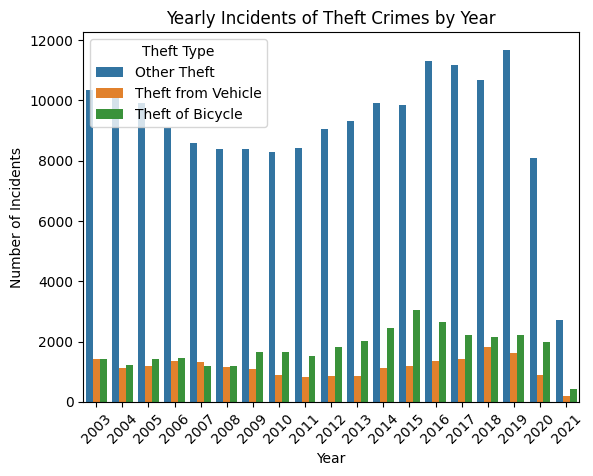

In [ ]:
import seaborn as sns

query3 = spark.sql( """
SELECT TYPE, YEAR, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, YEAR
ORDER BY YEAR, TYPE
""")

result3 = query3.toPandas()

# Create a stacked bar plot
sns.barplot(data=result3, x='YEAR', y='Count', hue='TYPE', ci=None)
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Yearly Incidents of Theft Crimes by Year')
plt.xticks(rotation=45)
plt.legend(title='Theft Type')
plt.show()

What are the peak times for different types of theft crimes during a 24-hour period?

<ipython-input-118-182b09065707>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=query4_df, x='HOUR', y='Count', hue='TYPE', ci=None)


Text(0.5, 1.0, 'Peak Times for Different Types of Theft Crimes')

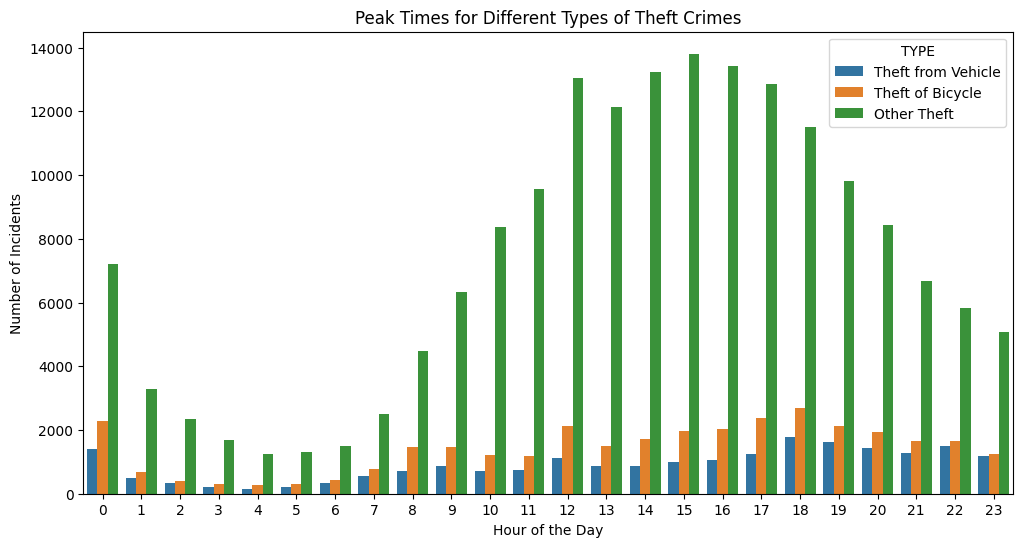

In [ ]:
query4 = spark.sql("""
SELECT TYPE, HOUR, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, HOUR
ORDER BY Count, HOUR DESC
""")

query4_df = query4.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=query4_df, x='HOUR', y='Count', hue='TYPE', ci=None)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.title('Peak Times for Different Types of Theft Crimes')

How do theft crime patterns differ between neighbourhoods?

<ipython-input-80-a842a1f7f3c6>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=result5_df, x='TYPE', y='Count', hue='NEIGHBOURHOOD', ci=None)


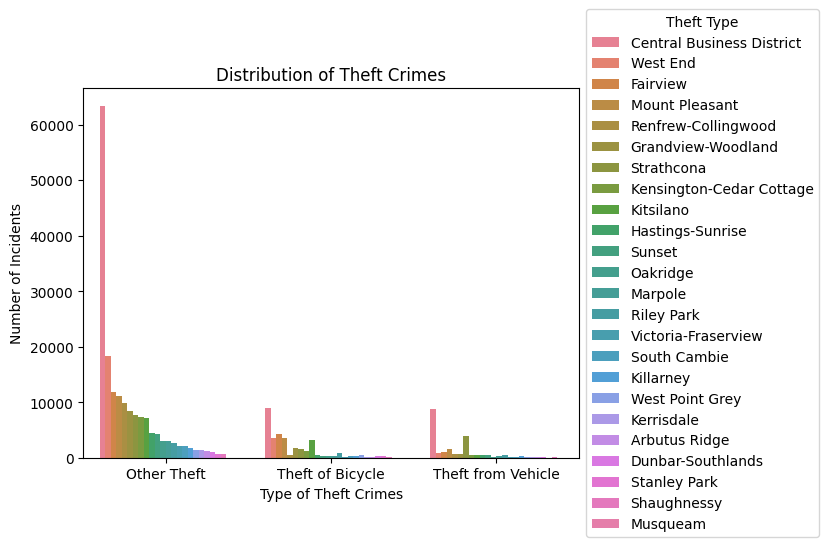

In [ ]:
query5 = spark.sql("""
SELECT TYPE, NEIGHBOURHOOD, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, NEIGHBOURHOOD
ORDER BY Count DESC
""")

result5_df = query5.toPandas()
# Create a stacked bar plot
sns.barplot(data=result5_df, x='TYPE', y='Count', hue='NEIGHBOURHOOD', ci=None)
plt.xlabel('Type of Theft Crimes')
plt.ylabel('Number of Incidents')
plt.title('Distribution of Theft Crimes')
plt.legend(title='Theft Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

What are the high-risk hours and locations for theft from vehicles?

In [ ]:
query7 = spark.sql("""
SELECT TYPE, HOUR, HUNDRED_BLOCK, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE = 'Theft from Vehicle'
GROUP BY TYPE, HOUR, HUNDRED_BLOCK
ORDER BY Count DESC
""")

result7_df = query7.toPandas()

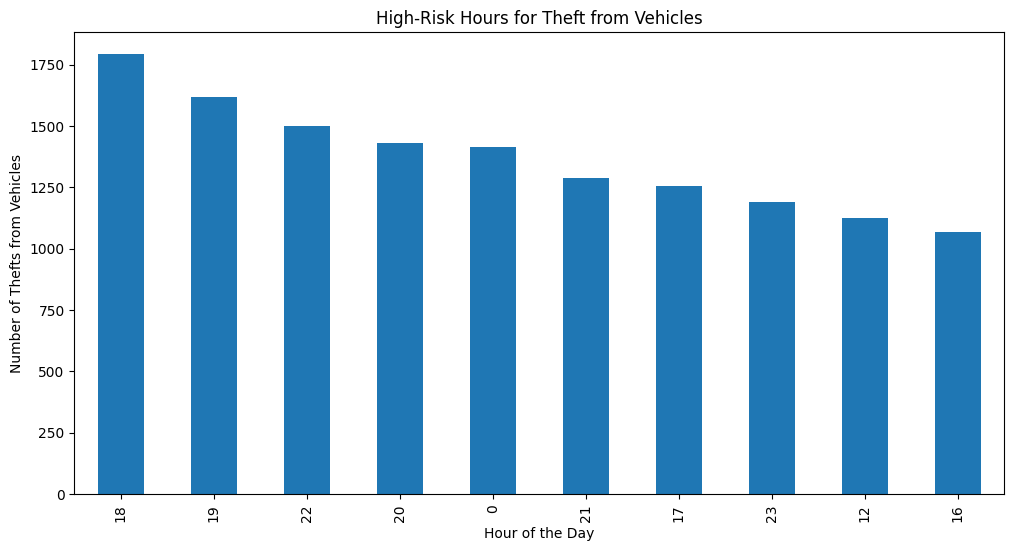

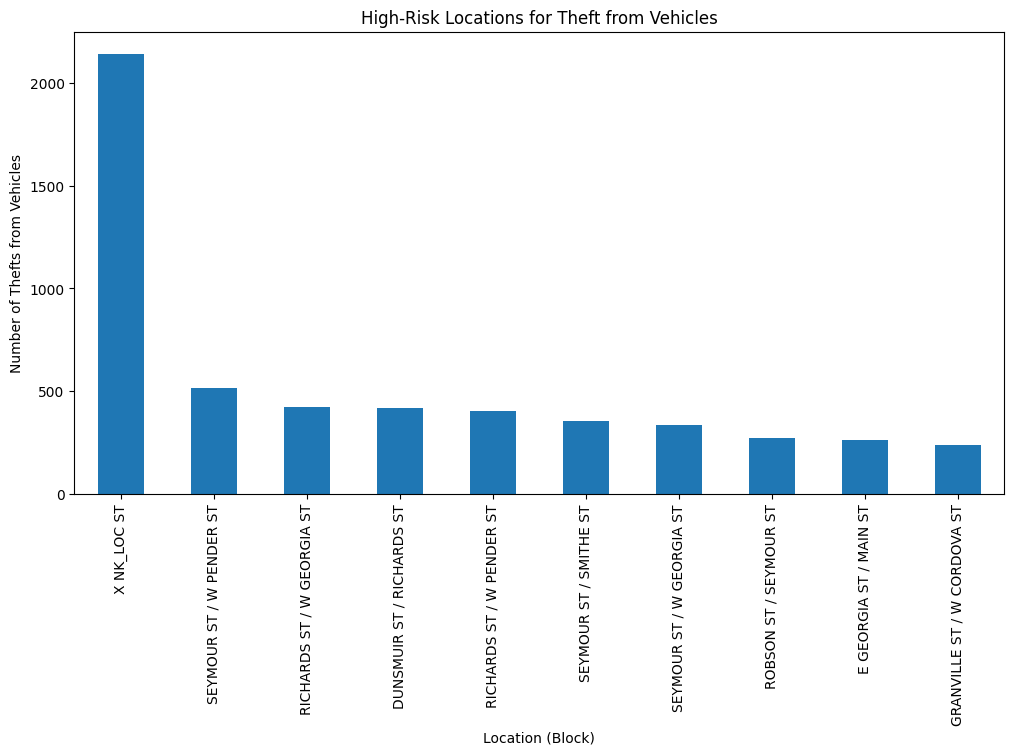

In [ ]:
# Plot high-risk hours (top 10)
top_hours = result7_df.groupby("HOUR")['Count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_hours.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Thefts from Vehicles')
plt.title('High-Risk Hours for Theft from Vehicles')

# Plot high-risk locations (top 10)
top_locations = result7_df.groupby("HUNDRED_BLOCK")['Count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_locations.plot(kind='bar')
plt.xlabel('Location (Block)')
plt.ylabel('Number of Thefts from Vehicles')
plt.title('High-Risk Locations for Theft from Vehicles')
plt.show()

Which blocks have the highest concentration of theft crimes, and how do these hotspots evolve?

In [ ]:
query8 = spark.sql("""
SELECT TYPE, HUNDRED_BLOCK, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, HUNDRED_BLOCK
ORDER BY Count DESC
LIMIT 10
""")

result8_df = query8.toPandas()

# Filter the data to include only the high-risk blocks
high_risk_block_ids = result8_df['HUNDRED_BLOCK'].tolist()
high_risk_blocks = result8_df[result8_df['HUNDRED_BLOCK'].isin(high_risk_block_ids)]
display(high_risk_blocks)

# Create a Spark DataFrame for the high-risk blocks
high_risk_blocks_spark.createOrReplaceTempView("high_risk_blocks")

# Query to get the trend of theft from vehicles in high-risk blocks last 5 months
result_highrisk = spark.sql("""
SELECT HUNDRED_BLOCK, YEAR, MONTH, COUNT(*) AS Count
FROM CrimeData
WHERE YEAR = 2021 AND HUNDRED_BLOCK IN (SELECT HUNDRED_BLOCK FROM high_risk_blocks)
GROUP BY HUNDRED_BLOCK, YEAR, MONTH
ORDER BY HUNDRED_BLOCK, MONTH
""")

result_highrisk.show()

,TYPE,HUNDRED_BLOCK,Count
0,Other Theft,7XX GRANVILLE ST,5686
1,Other Theft,6XX GRANVILLE ST,3347
2,Other Theft,31XX GRANDVIEW HWY,2902
3,Other Theft,7XX W GEORGIA ST,2639
4,Other Theft,3XX ABBOTT ST,2519
5,Theft from Vehicle,X NK_LOC ST,2143
6,Other Theft,17XX E BROADWAY AVE,2106
7,Other Theft,9XX GRANVILLE ST,2096
8,Other Theft,23XX CAMBIE ST,2086
9,Other Theft,5XX W HASTINGS ST,2080


+-------------------+----+-----+-----+
|      HUNDRED_BLOCK|YEAR|MONTH|Count|
+-------------------+----+-----+-----+
|17XX E BROADWAY AVE|2021|    1|    6|
|17XX E BROADWAY AVE|2021|    2|    9|
|17XX E BROADWAY AVE|2021|    3|    7|
|17XX E BROADWAY AVE|2021|    4|    5|
|17XX E BROADWAY AVE|2021|    5|    4|
|     23XX CAMBIE ST|2021|    1|    6|
|     23XX CAMBIE ST|2021|    2|    8|
|     23XX CAMBIE ST|2021|    3|   15|
|     23XX CAMBIE ST|2021|    4|   10|
|     23XX CAMBIE ST|2021|    5|    2|
| 31XX GRANDVIEW HWY|2021|    1|   56|
| 31XX GRANDVIEW HWY|2021|    2|   53|
| 31XX GRANDVIEW HWY|2021|    3|   52|
| 31XX GRANDVIEW HWY|2021|    4|   39|
| 31XX GRANDVIEW HWY|2021|    5|   25|
|      3XX ABBOTT ST|2021|    1|    4|
|      3XX ABBOTT ST|2021|    2|    4|
|      3XX ABBOTT ST|2021|    3|    2|
|      3XX ABBOTT ST|2021|    4|    4|
|  5XX W HASTINGS ST|2021|    1|    4|
+-------------------+----+-----+-----+
only showing top 20 rows



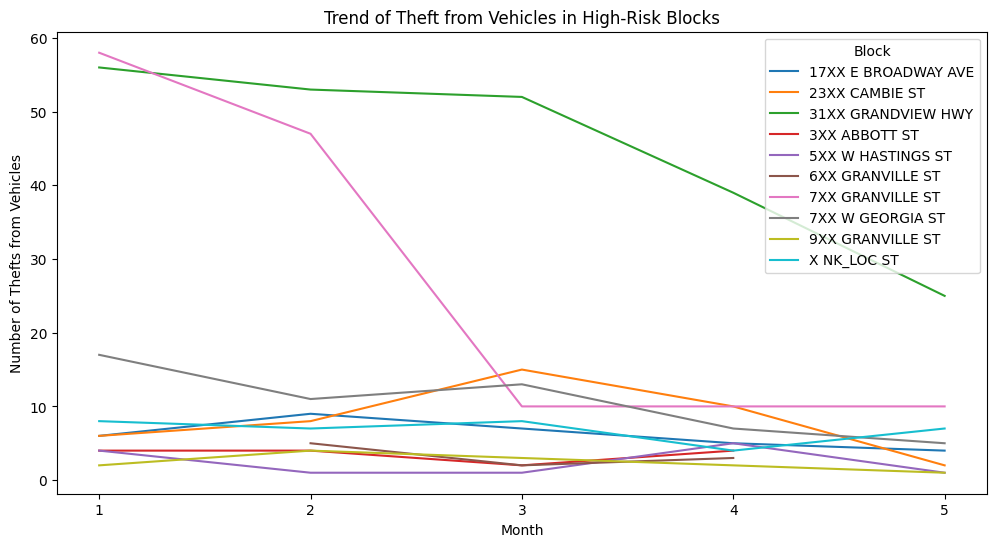

In [ ]:
# Plot the trend for each high-risk block for last 12 months
result_highrisk_pd = result_highrisk.toPandas() # Convert PySpark DataFrame to Pandas DataFrame

plt.figure(figsize=(12, 6))
sns.lineplot(data=result_highrisk_pd, x='MONTH', y='Count', hue='HUNDRED_BLOCK') # Use the Pandas DataFrame
plt.xlabel('Month')
plt.ylabel('Number of Thefts from Vehicles')
plt.title('Trend of Theft from Vehicles in High-Risk Blocks')
plt.legend(title='Block')
plt.xticks(range(1, 6)) # Set x-axis labels for each month
plt.show()



Are there specific areas with a high incidence of theft crimes during certain times of the year?

In [ ]:
query9 = """
WITH RankedCrimes AS (
    SELECT
        HUNDRED_BLOCK,
        TYPE,
        Month,
        COUNT(*) AS Count,
        ROW_NUMBER() OVER (PARTITION BY TYPE, Month ORDER BY COUNT(*) DESC) as Rank
    FROM
        CrimeData
    GROUP BY
        TYPE,
        Month,
        HUNDRED_BLOCK
)
SELECT
    HUNDRED_BLOCK,
    TYPE,
    Month,
    Count
FROM
    RankedCrimes
WHERE
    Rank <= 5
ORDER BY
    TYPE,
    Month,
    Rank
"""

result9_df = spark.sql(query9)
result9_df.show()

result9_pd_df = result9_df.toPandas()

+------------------+-----------+-----+-----+
|     HUNDRED_BLOCK|       TYPE|Month|Count|
+------------------+-----------+-----+-----+
|  7XX GRANVILLE ST|Other Theft|    1|  568|
|  6XX GRANVILLE ST|Other Theft|    1|  306|
|31XX GRANDVIEW HWY|Other Theft|    1|  287|
|  7XX W GEORGIA ST|Other Theft|    1|  259|
|     3XX ABBOTT ST|Other Theft|    1|  237|
|  7XX GRANVILLE ST|Other Theft|    2|  574|
|  6XX GRANVILLE ST|Other Theft|    2|  314|
|31XX GRANDVIEW HWY|Other Theft|    2|  273|
|  7XX W GEORGIA ST|Other Theft|    2|  251|
|     3XX ABBOTT ST|Other Theft|    2|  219|
|  7XX GRANVILLE ST|Other Theft|    3|  512|
|31XX GRANDVIEW HWY|Other Theft|    3|  307|
|  6XX GRANVILLE ST|Other Theft|    3|  295|
|  7XX W GEORGIA ST|Other Theft|    3|  247|
|     3XX ABBOTT ST|Other Theft|    3|  243|
|  7XX GRANVILLE ST|Other Theft|    4|  435|
|  6XX GRANVILLE ST|Other Theft|    4|  269|
|     3XX ABBOTT ST|Other Theft|    4|  245|
|31XX GRANDVIEW HWY|Other Theft|    4|  232|
|  7XX W G

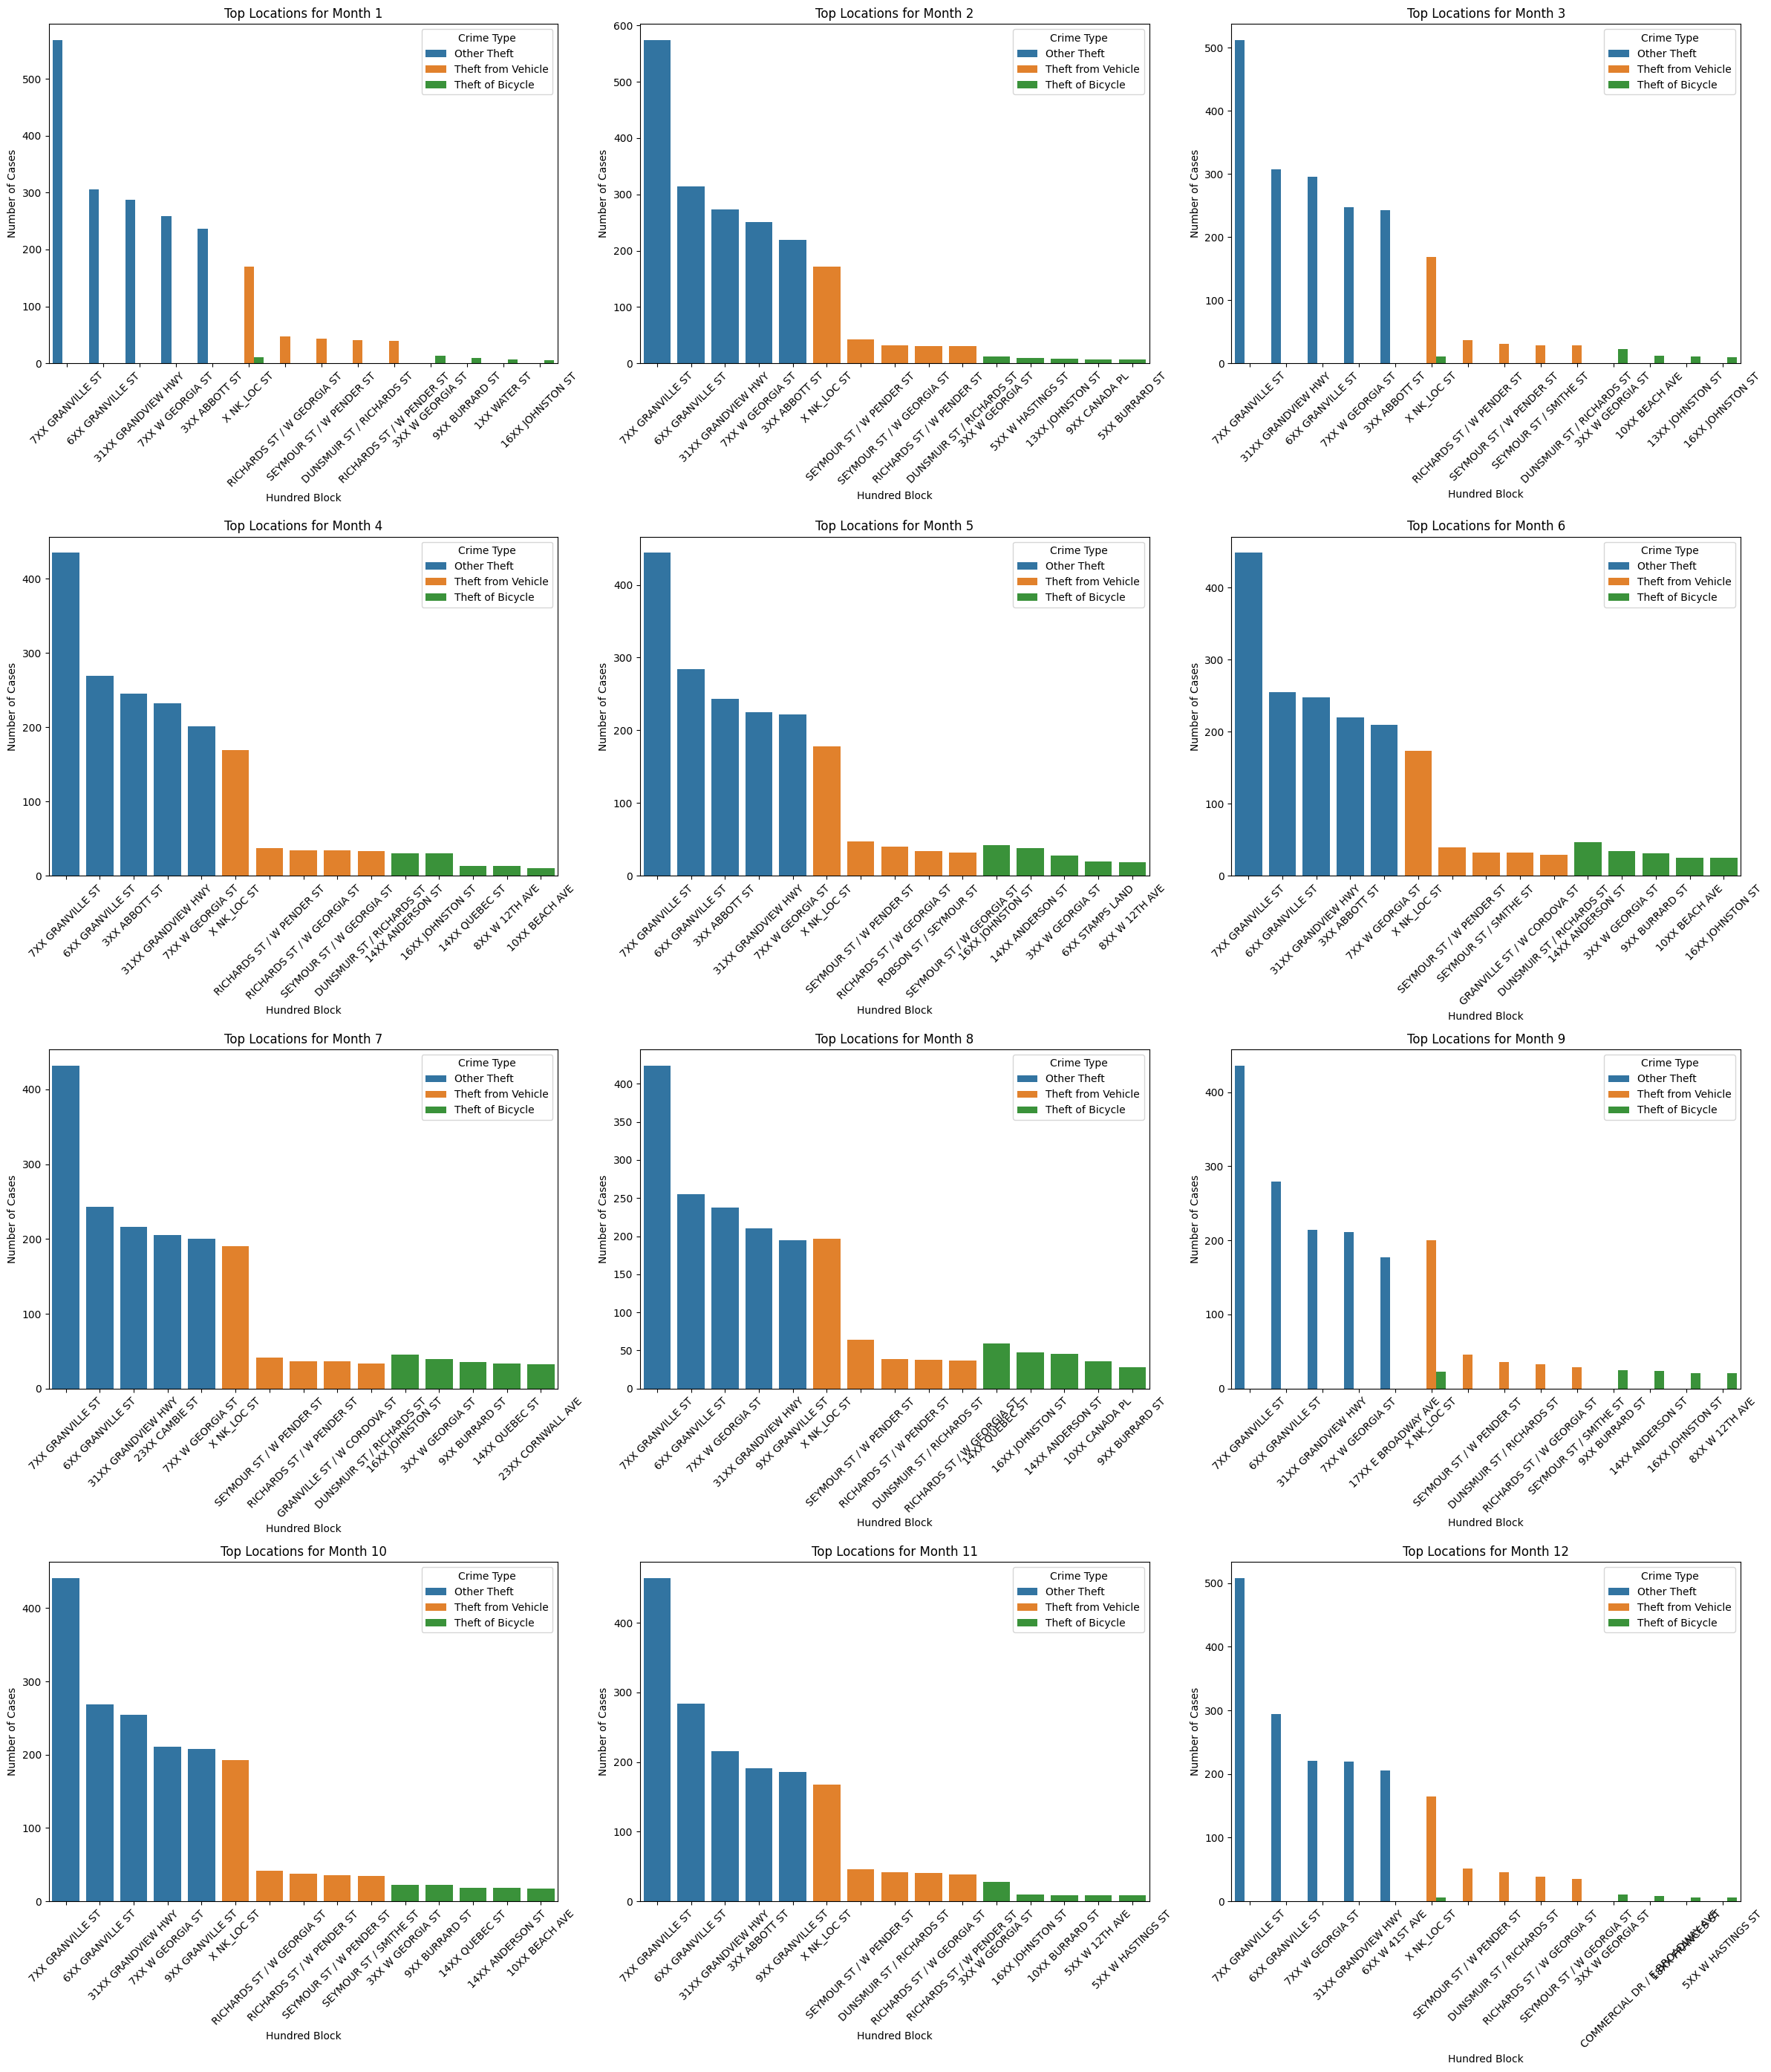

In [ ]:
months = sorted(result9_pd_df['Month'].unique())

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24,28))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_data = result9_pd_df[result9_pd_df['Month'] == month]

    # Create a bar plot for the current month
    sns.barplot(
        data=month_data,
        x='HUNDRED_BLOCK',
        y='Count',
        hue='TYPE',
        ax=axes[i],
        errorbar=None
    )
    axes[i].set_title(f'Top Locations for Month {month}')
    axes[i].set_xlabel('Hundred Block')
    axes[i].set_ylabel('Number of Cases')
    axes[i].legend(title='Crime Type')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots (if there are less than 12 months)
for i in range(len(months), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Are there any noticeable differences yearly when bicycle thefts occur versus other theft crimes?


In [ ]:
query10 = """
SELECT YEAR, MONTH, COUNT(*) AS Count, NEIGHBOURHOOD
FROM CrimeData
WHERE TYPE = 'Theft of Bicycle'
GROUP BY YEAR, MONTH, NEIGHBOURHOOD
ORDER BY YEAR, MONTH
"""

result10_df = spark.sql(query10)
result10_df.show()

result10_pd_df = result10_df.toPandas()

+----+-----+-----+--------------------+
|YEAR|MONTH|Count|       NEIGHBOURHOOD|
+----+-----+-----+--------------------+
|2003|    1|    1|    Hastings-Sunrise|
|2003|    1|    3|          Riley Park|
|2003|    1|   18|            West End|
|2003|    1|   16|Central Business ...|
|2003|    1|    1|            Oakridge|
|2003|    1|   26|           Kitsilano|
|2003|    1|    2|           Killarney|
|2003|    1|    3|          Strathcona|
|2003|    1|    6|  Grandview-Woodland|
|2003|    1|    6|      Mount Pleasant|
|2003|    1|    1|       Arbutus Ridge|
|2003|    1|    1| Renfrew-Collingwood|
|2003|    1|   10|            Fairview|
|2003|    1|    1|         Shaughnessy|
|2003|    1|    1|   Dunbar-Southlands|
|2003|    2|   14|           Kitsilano|
|2003|    2|    1|             Marpole|
|2003|    2|   15|Central Business ...|
|2003|    2|    2|     West Point Grey|
|2003|    2|    1|      Mount Pleasant|
+----+-----+-----+--------------------+
only showing top 20 rows



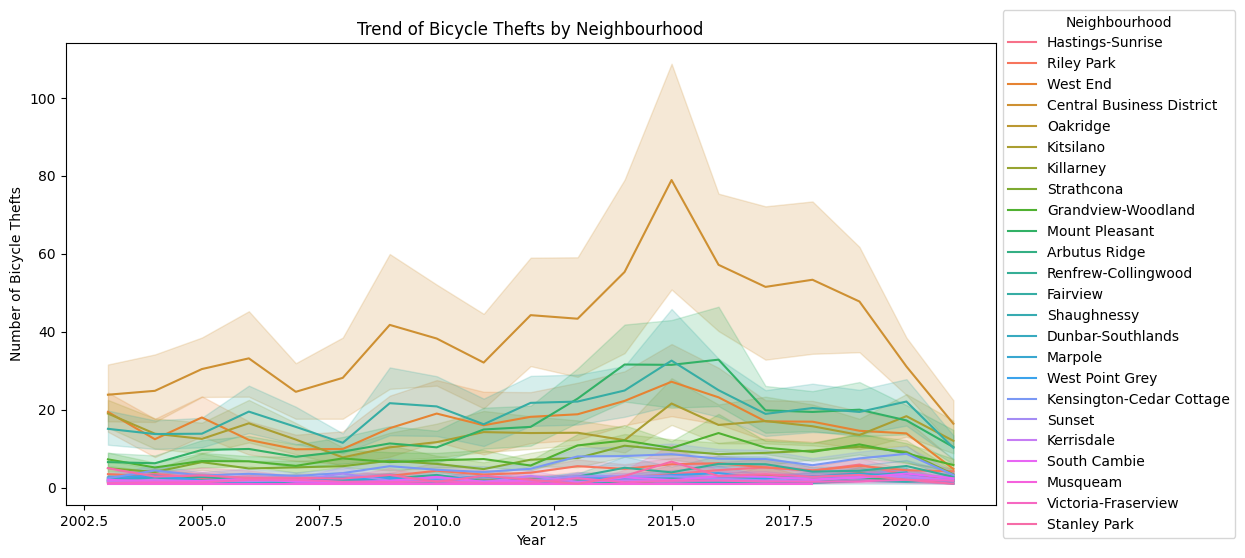

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=result10_pd_df, x='YEAR', y='Count', hue='NEIGHBOURHOOD')
plt.xlabel('Year')
plt.ylabel('Number of Bicycle Thefts')
plt.title('Trend of Bicycle Thefts by Neighbourhood')
plt.legend(title='Neighbourhood', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

How can predictive modeling help in identifying emerging hotspots for theft crimes?

ROC-AUC: 0.9999991400310786
ROC-AUC: 0.9999991400310786


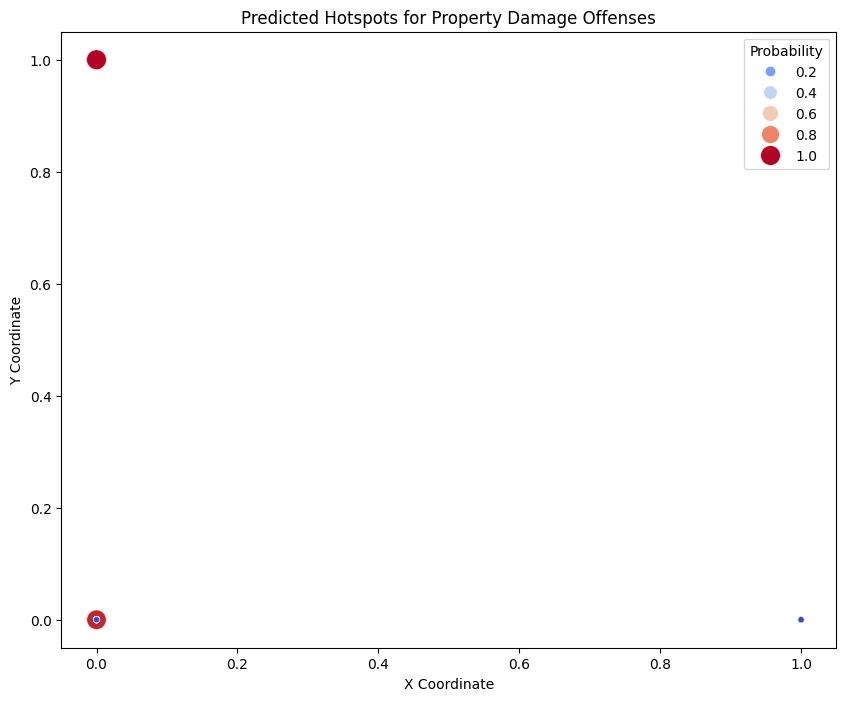

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when

# Check if columns already exist and drop if necessary
if 'TYPE_indexed' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('TYPE_indexed')
if 'HUNDRED_BLOCK_indexed' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('HUNDRED_BLOCK_indexed')
if 'TYPE_encoded' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('TYPE_encoded')
if 'HUNDRED_BLOCK_encoded' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('HUNDRED_BLOCK_encoded')


# Handle null values in StringIndexer
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="skip") for c in ["TYPE", "HUNDRED_BLOCK"]] # Set handleInvalid to 'skip'
encoders = [OneHotEncoder(inputCol="{0}_indexed".format(c), outputCol="{0}_encoded".format(c)) for c in ["TYPE", "HUNDRED_BLOCK"]]

# Update feature columns to use encoded columns
feature_columns = ["YEAR", "MONTH", "day", "HOUR", "TYPE_encoded", "HUNDRED_BLOCK_encoded"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Fit and transform the data using indexers and encoders
# Use df_assembled instead of df as it contains the 'TYPE' column
df_indexed = indexers[0].fit(df_assembled).transform(df_assembled)
df_encoded = encoders[0].fit(df_indexed).transform(df_indexed)
df_indexed = indexers[1].fit(df_encoded).transform(df_encoded)
df_encoded = encoders[1].fit(df_indexed).transform(df_indexed)

# Check if columns already exist and drop if necessary
if 'features' in df_encoded.columns:
    df_encoded = df_encoded.drop('features')
if 'TYPE_indexed' in df_encoded.columns:
    df_encoded = df_encoded.drop('TYPE_indexed')
if 'HUNDRED_BLOCK_indexed' in df_encoded.columns:
    df_encoded = df_encoded.drop('HUNDRED_BLOCK_indexed')

# Transform the data using the assembler (now with numeric features)
df_assembled = assembler.transform(df_encoded)

df_with_label = df_assembled.withColumn("label", when(df_assembled["TYPE"] == "Theft of Bicycle", 1).otherwise(0))

df = df_with_label.select("features", "label")

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Create a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Make predictions on the test set
predictions = lr_model.transform(test_data)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

# Make predictions on the test set
predictions = lr_model.transform(test_data)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model
roc_auc = evaluator.evaluate(predictions
print(f"ROC-AUC: {roc_auc}")

# Convert predictions to Pandas DataFrame for visualization
predictions_pd = predictions.select("features", "label", "prediction", "probability").toPandas()

# Extract coordinates and prediction probability
predictions_pd['X'] = predictions_pd['features'].apply(lambda x: float(x[4]))
predictions_pd['Y'] = predictions_pd['features'].apply(lambda x: float(x[5]))
predictions_pd['probability'] = predictions_pd['probability'].apply(lambda x: float(x[1]))

# Plot hotspots based on prediction probabilities
plt.figure(figsize=(10, 8))
sns.scatterplot(data=predictions_pd, x='X', y='Y', hue='probability', palette='coolwarm', size='probability', sizes=(20, 200))
plt.title('Predicted Hotspots for Property Damage Offenses')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Probability')
plt.show()